In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import datetime as dt
from matplotlib import rc, pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from math import radians, cos, sin, asin, sqrt

pd.set_option('display.width', 1500)

def haversine(row):
    # convert decimal degrees to radians     
    #convert lon, lat to floats
    row['FROM LONGITUDE'], row['FROM LATITUDE'], row['TO LONGITUDE'], row['TO LATITUDE'] = \
          map(float, [row['FROM LONGITUDE'], row['FROM LATITUDE'], row['TO LONGITUDE'], row['TO LATITUDE']])
    lon1, lat1, lon2, lat2 = \
          map(radians, [row['FROM LONGITUDE'], row['FROM LATITUDE'], row['TO LONGITUDE'], row['TO LATITUDE']])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    
    c = 2 * asin(sqrt(a))    
    r = 3956  # Radius of earth in kilometers. Use 3956 for miles 6371km for km
    
    return c * r

In [3]:
#average air temperature data for all of 2013
weatherByMonth = pd.concat([pd.read_csv("/Users/divya/projects/pandas/divvy-example/visuals/averageweather.txt", 
                            delim_whitespace=True).assign(Year=2013),
                pd.read_csv("/Users/divya/projects/pandas/divvy-example/averageweather2014.txt", 
                            delim_whitespace=True).assign(Year=2014), 
                pd.read_csv("/Users/divya/projects/pandas/divvy-example/averageweather2015.txt", 
                            delim_whitespace=True).assign(Year=2015),
                pd.read_csv("/Users/divya/projects/pandas/divvy-example/averageweather2016.txt", 
                            delim_whitespace=True).assign(Year=2016)]).reset_index(drop=True)

weatherByMonth["ATF"] = weatherByMonth["AT"] * (9/5) + 32

In [36]:
CONN = sql.connect("/Users/divya/projects/pandas/divvy-example/Divvy_Trips.db")
stations = "SELECT * FROM temp WHERE [FROM STATION ID] = 90 OR [TO STATION ID] = 90";
station = pd.read_sql(stations, con = CONN)
CONN.close()

In [37]:
#separate by month
#30 days in sept, april june and november, all the rest have 31, except feb with 28
# df['Month'] = np.where(df['DOY'].between(1,31, inclusive = True), 1, #31
#                 np.where(df['DOY'].between(32, 59, inclusive = True,), 2, #28
#                   np.where(df['DOY'].between(60, 90, inclusive = True,), 3,
#                     np.where(df['DOY'].between(91, 120, inclusive = True,), 4, #30
#                       np.where(df['DOY'].between(121, 151, inclusive = True,), 5,
#                         np.where(df['DOY'].between(152, 181, inclusive = True,), 6, #30
#                           np.where(df['DOY'].between(182, 212, inclusive = True,), 7,
#                             np.where(df['DOY'].between(213, 243, inclusive = True,), 8,
#                               np.where(df['DOY'].between(244, 273, inclusive = True,), 9, #30
#                                 np.where(df['DOY'].between(274, 304, inclusive = True,), 10,
#                                   np.where(df['DOY'].between(305, 334, inclusive = True,), 11, #30
#                                     np.where(df['DOY'].between(335, 365, inclusive = True,), 12, np.nan))))))))))))

def create_month(x):
    return dt.datetime.strptime("{0}-{1}".format(int(x['DOY']),int(x['Year'])), '%j-%Y').month
    
weatherByMonth.loc[:, 'Month'] = weatherByMonth.apply(create_month, axis=1)

weatherByMonth = weatherByMonth.rename(columns={'AT': 'Air Temp', 'WS': 'Wind Speed'})

weatherByMonths = weatherByMonth.groupby(['Month'])['Air Temp', 'Wind Speed', 'ATF'].apply(np.mean)
weatherByMonths = weatherByMonths.reset_index()

weatherByMonths.to_csv("/Users/divya/projects/pandas/divvy-example/weatherByData.csv", index=False)
weatherByMonths

,Month,Air Temp,Wind Speed,ATF
0,1,-4.164677,8.440968,27.835323
1,2,-4.338142,7.931062,27.661858
2,3,1.570806,7.357177,33.570806
3,4,7.289417,7.337667,39.289417
4,5,13.538468,6.667581,45.538468
5,6,18.374250,5.737083,50.374250
6,7,21.674435,5.605081,53.674435
7,8,22.411694,5.291129,54.411694
8,9,19.848167,6.501250,51.848167
9,10,13.344758,7.607661,45.344758


In [38]:
station['DISTANCE_Miles'] = station.apply(haversine, axis=1)
station["START TIME"] = pd.to_datetime(station["START TIME"], format="%m/%d/%Y %I:%M:%S %p")
station["STOP TIME"] = pd.to_datetime(station["STOP TIME"], format="%m/%d/%Y %I:%M:%S %p")

station.loc[:, 'START TIME MONTH'] = station['START TIME'].dt.month
station.loc[:, 'START TIME YEAR'] = station['START TIME'].dt.year

station.loc[:, 'STOP TIME MONTH'] = station['STOP TIME'].dt.month
station.loc[:, 'STOP TIME YEAR'] = station['STOP TIME'].dt.year

In [39]:
avDistanceByGender = pd.pivot_table(station[(station['GENDER'] != '')] , 
                                    index=['START TIME MONTH'], columns=['GENDER'],
                                    values=['DISTANCE_Miles'], aggfunc=np.sum)

avDistanceByGender

DISTANCE_Miles             
GENDER                   Female         Male
START TIME MONTH                            
1                    297.440299  1225.691898
2                    266.133640  1235.443229
3                    755.038653  2507.177503
4                   1067.162973  3800.534839
5                   2118.003940  5691.328220
6                   3937.104108  8378.635049
7                   3011.389302  7022.414424
8                   2965.019648  6852.959425
9                   2317.871839  5939.488382
10                  1441.376798  5271.593108
11                   929.640649  3012.916879
12                   498.295348  1992.728910

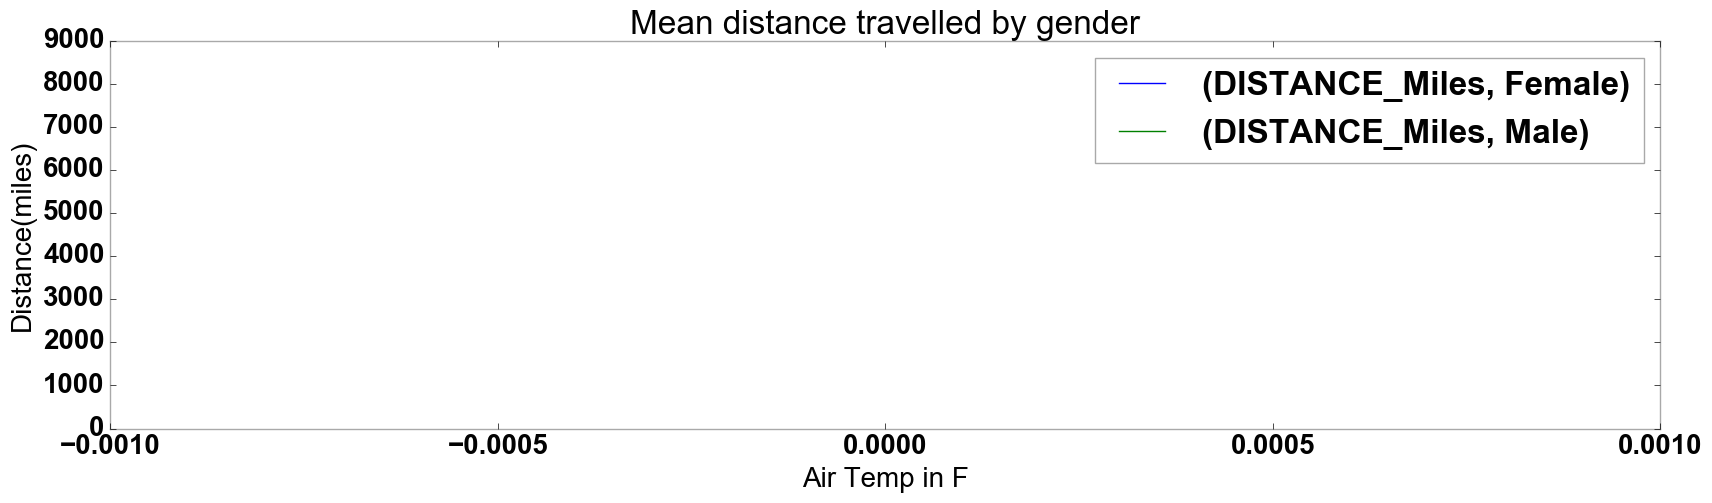

,"(DISTANCE_Miles, Female)","(DISTANCE_Miles, Male)",Month,Air Temp,Wind Speed,START TIME MONTH
ATF,,,,,,
27.661858,297.440299,1225.691898,2.0,-4.338142,7.931062,1
31.868655,929.640649,3012.916879,12.0,-0.131345,7.937059,11
33.570806,266.133640,1235.443229,3.0,1.570806,7.357177,2
38.141083,1441.376798,5271.593108,11.0,6.141083,8.746000,10
39.289417,755.038653,2507.177503,4.0,7.289417,7.337667,3
45.344758,2317.871839,5939.488382,10.0,13.344758,7.607661,9
45.538468,1067.162973,3800.534839,5.0,13.538468,6.667581,4
50.374250,2118.003940,5691.328220,6.0,18.374250,5.737083,5
51.848167,2965.019648,6852.959425,9.0,19.848167,6.501250,8


In [40]:
total = avDistanceByGender.join(weatherByMonths)
total

font = {'family' : 'arial', 'weight' : 'bold', 'size': 20}
rc('font', **font); rc("figure", facecolor="white"); rc('axes', edgecolor='darkgray');

DistancevsWeather = total.sort_values(['ATF'])
DistancevsWeather["START TIME MONTH"] = DistancevsWeather.index.values
DistancevsWeather = DistancevsWeather.set_index(['ATF'])

line = DistancevsWeather[[0,1]].plot(title="Mean distance travelled by gender", figsize=(20,5))
line.set_ylabel("Distance(miles)")
line.set_xlabel("Air Temp in F")
plt.show()
DistancevsWeather

In [41]:
DistancevsWeather

,"(DISTANCE_Miles, Female)","(DISTANCE_Miles, Male)",Month,Air Temp,Wind Speed,START TIME MONTH
ATF,,,,,,
27.661858,297.440299,1225.691898,2.0,-4.338142,7.931062,1
31.868655,929.640649,3012.916879,12.0,-0.131345,7.937059,11
33.570806,266.133640,1235.443229,3.0,1.570806,7.357177,2
38.141083,1441.376798,5271.593108,11.0,6.141083,8.746000,10
39.289417,755.038653,2507.177503,4.0,7.289417,7.337667,3
45.344758,2317.871839,5939.488382,10.0,13.344758,7.607661,9
45.538468,1067.162973,3800.534839,5.0,13.538468,6.667581,4
50.374250,2118.003940,5691.328220,6.0,18.374250,5.737083,5
51.848167,2965.019648,6852.959425,9.0,19.848167,6.501250,8


In [42]:
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],
                        'B': ['B0', 'B1', 'B2', 'B3'],
                        'C': ['C0', 'C1', 'C2', 'C3'],
                        'D': ['D0', 'D1', 'D2', 'D3']},
                        index=[0, 1, 2, 3])

df2 = pd.DataFrame([['A0', 'A1', 'A2', 'A3'],
                    ['B0', 'B1', 'B2', 'B3'],
                    ['C0', 'C1', 'C2', 'C3'],
                    ['D0', 'D1', 'D2', 'D3']],
                   index=[0, 1, 2, 3],
                  columns=['A', 'B', 'C', 'D'])

df1 = pd.Series(['A0', 'B0', 'C0', 'D0'])

df1

# df4 = pd.DataFrame({'B': ['B2', 'B3', 'B6', 'B7'],
#                      'D': ['D2', 'D3', 'D6', 'D7'],
#                      'F': ['F2', 'F3', 'F6', 'F7']},
#                     index=[2, 3, 6, 7])

# pd.concat([df1, df4], axis=1)

0    A0
1    B0
2    C0
3    D0
dtype: object

In [43]:
rain = pd.read_csv("/Users/divya/projects/pandas/divvy-example/precipitation.csv")
rain = rain.drop(['STATION_NAME', 'STATION', 'ELEVATION', 'LATITUDE', 'LONGITUDE','Quality Flag'], 1)
rain
#remove T which is an indication of incorrect/missing data

rain = rain[rain['Measurement Flag'] != 'T']
rain = rain[rain['HPCP'] != 99999]

rain.loc[:, 'DATE'] = pd.to_datetime(rain["DATE"], format="%Y%m%d %H:%M")

rain = rain.set_index('DATE')
rain = rain[rain['HPCP'] < 999.99]

In [44]:
# #Run once only 
# def convert_date(x):
#     return dt.datetime.strptime("{}".format(x), '%Y%m%d %H:%M')

# rain["DATE"] = rain["DATE"].map(convert_date)

In [45]:
#rain.loc[:, "Month"] = rain["DATE"].map(lambda x: dt.datetime.strptime("{}".format(x), '%Y-%m-%d %H:%M:%S').month)

In [46]:
#rain.loc[:, "Year"] = rain["DATE"].map(lambda x: dt.datetime.strptime("{}".format(x), '%Y-%m-%d %H:%M:%S').year)

In [47]:
# in hundredths of inches #
# precipitation = pd.pivot_table(rain[rain["Year"] == 2013], index=["Month"], values=["HPCP", "Measurement Flag"], aggfunc=sum)
# precipitation
#rain[rain["HPCP"] > 999]

In [48]:
# cumulative = joined.join(precipitation)
# cumulative.columns

# #hundredths of inches
# precipitation.columns = ['Precipitation per hour']
#cumulative.groupby(['DISTANCE_Miles', 'Female'])['AT'].describe

In [49]:
#bad graph
# line = cumulative.plot(title="Mean distance travelled by gender", figsize=(20,5))
# line.set_ylabel("Distance(miles)")
# line.set_xlabel("Time")
# plt.show()

In [50]:
# rainfall = precipitation.plot(title="Mean distance travelled by gender", figsize=(20,5))
# rainfall.set_ylabel("")
# rainfall.set_xlabel("Time")
# plt.show()

In [51]:
#rain[rain['HPCP'] > 5]

In [52]:
#cumulative.sort_vaues
#avDistanceByGender2013.ix[2013]


In [53]:
divvyStation = station[station['START TIME YEAR'] == 2013][['START TIME','TRIP ID']].set_index(['START TIME'], drop=True)
divvyStation = divvyStation.resample('H').count()

tripsvsRain = divvyStation.join(rain)
# tripsvsRain = tripsvsRain.groupby(['HPCP']).apply(sum)
tripsvsRain = tripsvsRain[tripsvsRain['HPCP'] < 10][['HPCP', 'TRIP ID']].sort_values(['HPCP'])

In [54]:
station[station['START TIME YEAR'] == 2013]

,TRIP ID,START TIME,STOP TIME,BIKE ID,TRIP DURATION,FROM STATION ID,FROM STATION NAME,TO STATION ID,TO STATION NAME,USER TYPE,...,TO LOCATION,Boundaries - ZIP Codes,Zip Codes,Community Areas,Wards,DISTANCE_Miles,START TIME MONTH,START TIME YEAR,STOP TIME MONTH,STOP TIME YEAR
168808,1109065,2013-12-31 18:02:00,2013-12-31 18:11:00,2991,565,90,Millennium Park,59,Wabash Ave & Roosevelt Rd,Subscriber,...,POINT (-87.625961 41.867227),34,14309,38,36,0.958020,12,2013,12,2013
168809,1108989,2013-12-31 16:48:00,2013-12-31 16:59:00,121,666,90,Millennium Park,81,Daley Center Plaza,Subscriber,...,POINT (-87.629892 41.884451),34,14309,38,36,0.380612,12,2013,12,2013
168810,1108988,2013-12-31 16:47:00,2013-12-31 17:00:00,84,738,90,Millennium Park,81,Daley Center Plaza,Customer,...,POINT (-87.629892 41.884451),34,14309,38,36,0.380612,12,2013,12,2013
168811,1108848,2013-12-31 15:03:00,2013-12-31 15:08:00,84,343,283,LaSalle St & Jackson Blvd,90,Millennium Park,Subscriber,...,POINT (-87.624084 41.881032),29,14912,38,36,0.451666,12,2013,12,2013
168812,1108775,2013-12-31 14:21:00,2013-12-31 14:34:00,121,766,110,State St & Erie St,90,Millennium Park,Subscriber,...,POINT (-87.624084 41.881032),55,4446,37,36,0.934410,12,2013,12,2013
168813,1108620,2013-12-31 13:10:00,2013-12-31 13:14:00,1194,209,90,Millennium Park,52,Michigan Ave & Lake St,Subscriber,...,POINT (-87.624117 41.886024),34,14309,38,36,0.344699,12,2013,12,2013
168814,1108423,2013-12-31 10:54:00,2013-12-31 11:05:00,2857,682,168,Michigan Ave & 14th St,90,Millennium Park,Subscriber,...,POINT (-87.624084 41.881032),35,14913,34,9,1.172028,12,2013,12,2013
168815,1108301,2013-12-31 08:57:00,2013-12-31 09:01:00,1338,248,90,Millennium Park,49,Dearborn St & Monroe St,Subscriber,...,POINT (-87.629521 41.88132),34,14309,38,36,0.280183,12,2013,12,2013
168816,1108255,2013-12-31 08:29:00,2013-12-31 08:36:00,1275,430,191,Canal St & Monroe St,90,Millennium Park,Subscriber,...,POINT (-87.624084 41.881032),46,14914,29,36,0.791256,12,2013,12,2013
168817,1108236,2013-12-31 08:21:00,2013-12-31 08:30:00,2860,580,91,Clinton St & Washington Blvd,90,Millennium Park,Subscriber,...,POINT (-87.624084 41.881032),45,4452,29,36,0.893138,12,2013,12,2013


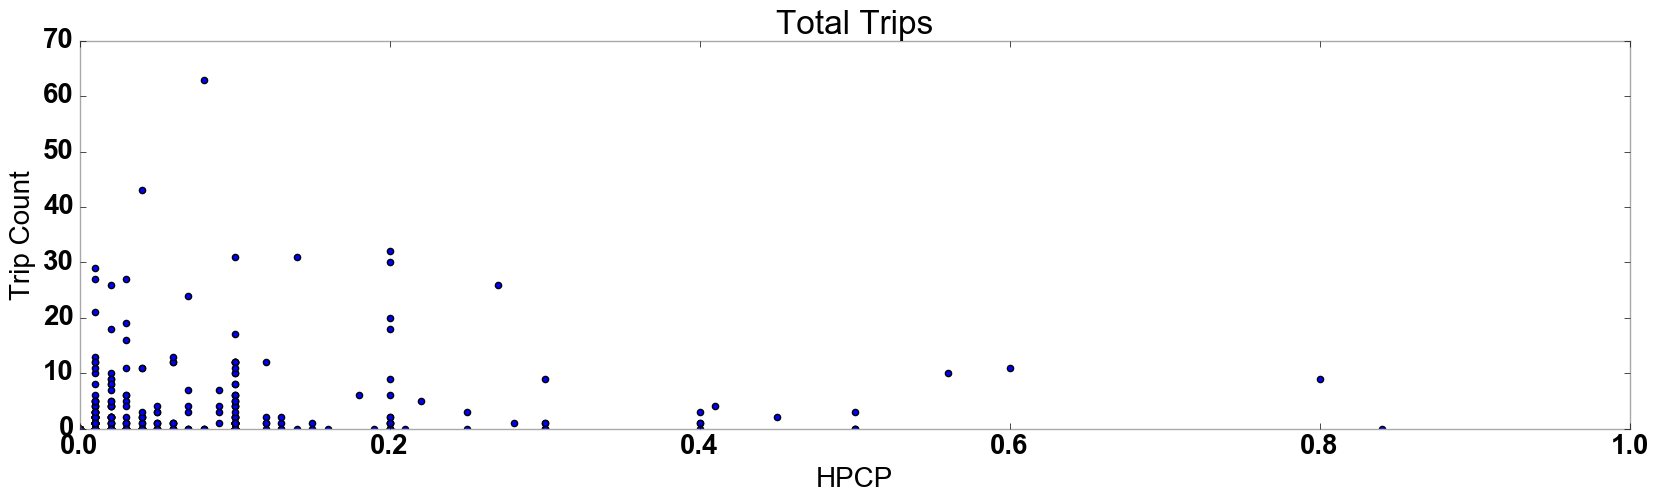

In [55]:
line = tripsvsRain.plot.scatter(x=0, y= 1,title="Total Trips", figsize=(20,5), xlim=[0,1.0], ylim=[0, 70])
line.set_ylabel("Trip Count")
line.set_xlabel("HPCP")
plt.show()

In [56]:
tripsvsRain

,HPCP,TRIP ID
2013-12-01 01:00:00,0.00,0
2013-08-01 01:00:00,0.00,0
2013-11-01 01:00:00,0.00,0
2013-08-01 01:00:00,0.00,0
2013-11-01 01:00:00,0.00,0
2013-12-01 01:00:00,0.00,0
2013-09-01 01:00:00,0.00,0
2013-10-01 01:00:00,0.00,0
2013-10-01 01:00:00,0.00,0
2013-07-01 01:00:00,0.00,0
